[Home](index.ipynb) > [Data Collections](data_collections.ipynb) > Elite families

<img style='float: left;' src='https://www.gesis.org/fileadmin/styles/img/gs_home_logo_en.svg'>

### ``compsoc`` – *Notebooks for Computational Sociology* (alpha)

# Copenhagen Networks Study: Multiplex interactions among 845 university students
Authors: [Haiko Lietz](https://www.gesis.org/person/haiko.lietz)

Version: 0.91 (14.09.2020)

Please cite as: Lietz, Haiko (2020). Copenhagen Networks Study: Multiplex interactions among 845 university students. Version 0.91 (14.09.2020). *compsoc – Notebooks for Computational Sociology*. GESIS. url:[github.com/gesiscss/compsoc](https://github.com/gesiscss/compsoc)

<div class="alert alert-info">
<big><b>Significance</b></big>

The Copenhagen Networks Study collection is a prime source of digital behavioral data. It provides four types of tie (physical proximity, calls, short messages, and Facebook friendships) among a fixed set of almost 1000 persons. The availability of a gender attribute allows for additional analyses and modeling approaches.
</div>

## Introduction
This data is describes by Sapiezynski et al. ([2019](https://doi.org/10.1038/s41597-019-0325-x)). It is made freely available under an MIT License at [figshare](https://doi.org/10.6084/m9.figshare.7267433).

**In this notebook**, we develop a function that loads and normalizes all data of the Copenhagen Networks Study. Bringing it to the standard form makes it compatible with the `compsoc` tools.

## Dependencies and settings

In [1]:
import compsoc as cs
import itertools
import networkx as nx
import numpy as np
import pandas as pd

## Copenhagen Networks Study interaction data
The dataset contains four types of tie and a user attribute.

First type of tie: **Network of physical proximity** among the participants (estimated via Bluetooth signal strength).

In [2]:
bluetooth = pd.read_csv('data/copenhagen/bt_symmetric.csv')

In [3]:
print(bluetooth.columns)

Index(['# timestamp', 'user_a', 'user_b', 'rssi'], dtype='object')


In [4]:
print(open('data/copenhagen/bt_symmetric.README', 'r').read())

column names:
	- timestamp
	- user A 
	- user B 
	- received signal strength

Notes:
Empty scans are marked with user B = -1 and RSSI = 0
Scans of devices outside of the experiment are marked with user B = -2. All non-experiment devices are given the same ID.



Second type of tie: **Network of phone calls** (start time, duration, no content).

In [5]:
calls = pd.read_csv('data/copenhagen/calls.csv')

In [6]:
print(calls.columns)

Index(['timestamp', 'caller', 'callee', 'duration'], dtype='object')


In [7]:
print(open('data/copenhagen/calls.README', 'r').read())

column names:
	- timestamp
	- calling user
	- call recipient
	- duration (-1 means a missed call)




Third type of tie: **Network of text messages** (time of message, no content).

In [8]:
sms = pd.read_csv('data/copenhagen/sms.csv')

In [9]:
print(sms.columns)

Index(['timestamp', 'sender', 'recipient'], dtype='object')


In [10]:
print(open('data/copenhagen/sms.README', 'r').read())

column names:
	- timestamp
	- sender
	- recipient



Fourth type of tie: **network of Facebook friendships**.

In [11]:
facebook_friends = pd.read_csv('data/copenhagen/fb_friends.csv')

In [12]:
print(facebook_friends.columns)

Index(['# user_a', 'user_b'], dtype='object')


In [13]:
print(open('data/copenhagen/fb_friends.README', 'r').read())

column names:
	- user A
	- user B

Edge lists of all declared facebook friendships which were formed before the end of the observation and not dissolved until after the end of the observation.



User attribute:

In [14]:
attributes = pd.read_csv('data/copenhagen/genders.csv')

In [15]:
print(attributes.columns)

Index(['# user', 'female'], dtype='object')


## Normalization
The goal of normalization is to bring this data into a standard form which is needed for methods to be applicable.
### ``users`` dataframe
The ``genders`` dataframe is not a complete list of users as some users that participated in relational data collection did not answer the gender question or did not participate in the survey. We must construct a ``users`` dataframe by finding the set of unique users, ...

In [16]:
users = set(itertools.chain(*[
    bluetooth['user_a'].to_list(), 
    bluetooth['user_b'].to_list(), 
    calls['caller'].to_list(), 
    calls['callee'].to_list(), 
    sms['sender'].to_list(), 
    sms['recipient'].to_list(), 
    facebook_friends['# user_a'].to_list(), 
    facebook_friends['user_b'].to_list(), 
    attributes['# user'].to_list()
]))

In [17]:
users = pd.DataFrame(list(users), columns=['user'])
users = users[users['user'] >= 0] # remove artifact users from bluetooth dataframe

... merging user ``attributes`` into it, ...

In [18]:
users = pd.merge(left=users, right=attributes, left_on='user', right_on='# user', how='left')

... coding missing gender as 2, ...

In [19]:
users.fillna(2, inplace=True)

... and cleaning up:

In [20]:
users.rename(columns={'female': 'gender_id'}, inplace=True)
users['gender_id'] = users['gender_id'].astype(int)
users.drop(['# user'], axis=1, inplace=True)
users['user_id'] = users.index
users = users[['user_id', 'user', 'gender_id']]

In [21]:
users.tail()

,user_id,user,gender_id
840,840,845,0
841,841,846,0
842,842,847,1
843,843,848,2
844,844,850,2


The observation that the largest normalized user identifier (``user_id``) is six user shorter than the unnormalized identifier (``user``) means that we avoid dragging along six users for which we do not have any data at all. Since we have created a ``gender_id``, we must also create a dataframe with descriptions of these identifiers:

In [22]:
genders = pd.DataFrame([[0, 'male'], [1, 'female'], [2, 'unknown']], columns=['gender_id', 'gender'])

In [23]:
genders

,gender_id,gender
0,0,male
1,1,female
2,2,unknown


### Relations dataframes
#### Bluetooth
The network of physical proximity is an undirected network.

In [24]:
bluetooth.head()

,# timestamp,user_a,user_b,rssi
0,0,0,-1,0
1,0,1,-1,0
2,0,2,-1,0
3,0,3,-2,-88
4,0,5,-1,0


The ``# timestamp`` column is a counter of seconds over four weeks. This function replaces such a timestamp column with ``['day', 'hour', 'minute', 'second']`` columns:

In [25]:
def replace_timestamp(df, timestamp):
    minute = (df[timestamp]/60).astype(int)
    hour = (minute/60).astype(int)
    day = (hour/24).astype(int).rename('day')
    hour = (hour-day*24).rename('hour')
    minute = (minute-day*24*60-hour*60).rename('minute')
    second = (df[timestamp]-day*24*60*60-hour*60*60-minute*60).rename('second')
    df.rename(columns={timestamp: 'time'}, inplace=True)
    df = pd.concat([df, day, hour, minute, second], axis=1)
    return df

In [26]:
bluetooth = replace_timestamp(bluetooth, '# timestamp')

Preprocess signal strength:

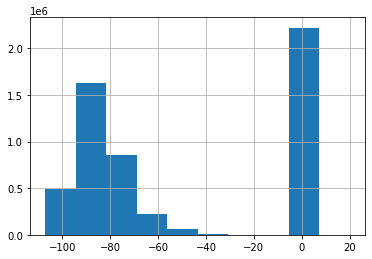

In [27]:
bluetooth['rssi'].hist()

In [28]:
bluetooth = bluetooth[bluetooth['rssi'] < 0]

Transform signal strength to more intuitive values:

In [29]:
bluetooth['rssi'] = bluetooth['rssi']+100

In [30]:
bluetooth.rename(columns={'rssi': 'strength'}, inplace=True)

Remove ties where no other study participant is found in the bluetooth range:

In [31]:
bluetooth = bluetooth[~bluetooth['user_b'].isin([-1, -2])]

The edge list still uses the unnormalized node identifiers. To replace them with the normalized ones, use this function:

In [32]:
def replace_identifier(df, old_identifier, new_identifier):
    df = pd.merge(left=df, right=users[['user', 'user_id']], left_on=old_identifier, right_on='user')
    df.rename(columns={'user_id': new_identifier}, inplace=True)
    df.drop([old_identifier, 'user'], axis=1, inplace=True)
    return df

In [33]:
bluetooth = replace_identifier(bluetooth, 'user_a', 'user_id_from')
bluetooth = replace_identifier(bluetooth, 'user_b', 'user_id_to')

Since ``bluetooth`` is the only undirected network but we may use it as a layer in a multiplex graph, we create a duplicate tie in the reverse direction:

In [34]:
bluetooth_reversed = bluetooth.copy()[['time', 'strength', 'day', 'hour', 'minute', 'second', 'user_id_to', 'user_id_from']]
bluetooth_reversed.columns = bluetooth.columns
bluetooth = bluetooth.append(bluetooth_reversed)

Now clean up:

In [35]:
bluetooth.sort_values(['time', 'user_id_from', 'user_id_to'], inplace=True)
bluetooth.reset_index(drop=True, inplace=True)
bluetooth = bluetooth[['user_id_from', 'user_id_to', 'strength', 'time', 'day', 'hour', 'minute', 'second']]

In [36]:
bluetooth.head()

,user_id_from,user_id_to,strength,time,day,hour,minute,second
0,12,244,30,0,0,0,0,0
1,12,454,25,0,0,0,0,0
2,16,572,30,0,0,0,0,0
3,19,47,14,0,0,0,0,0
4,20,21,27,0,0,0,0,0


The edge list for the network of physical proximity is now in the normalized form. The edges are defined in the first two columns, the edge weight is in the third column, and temporal columns can be used for slicing and filtering.

### Calls
The network of phone clls encodes who calls whom.

In [37]:
calls.head()

,timestamp,caller,callee,duration
0,184,300,301,121
1,3920,512,299,670
2,5623,301,300,504
3,9252,401,457,-1
4,15466,512,0,5


Replace the timestamps:

In [38]:
calls = replace_timestamp(calls, 'timestamp')

Replace the user identifiers:

In [39]:
calls = replace_identifier(calls, 'caller', 'user_id_from')
calls = replace_identifier(calls, 'callee', 'user_id_to')

Missed calls are coded as -1. Since negative values cannot be used as edge weights, we recode -1 to 0. Missed calls are then indistinguishable from clls that lasted 0 seconds.

In [40]:
calls['duration'].replace(-1, 0, inplace=True)

Clean up:

In [41]:
calls.sort_values(['time', 'user_id_from', 'user_id_to'], inplace=True)
calls.reset_index(drop=True, inplace=True)
calls = calls[['user_id_from', 'user_id_to', 'duration', 'time', 'day', 'hour', 'minute', 'second']]

In [42]:
calls.head()

,user_id_from,user_id_to,duration,time,day,hour,minute,second
0,300,301,121,184,0,0,3,4
1,512,299,670,3920,0,1,5,20
2,301,300,504,5623,0,1,33,43
3,401,457,0,9252,0,2,34,12
4,512,0,5,15466,0,4,17,46


### SMS
The network of text messages encodes who sends whom a short message.

In [43]:
sms.head()

,timestamp,sender,recipient
0,18,370,512
1,37,512,370
2,126,370,512
3,134,0,512
4,312,137,136


Replace the timestamps:

In [44]:
sms = replace_timestamp(sms, 'timestamp')

Replace the user identifiers:

In [45]:
sms = replace_identifier(sms, 'sender', 'user_id_from')
sms = replace_identifier(sms, 'recipient', 'user_id_to')

Clean up:

In [46]:
sms.sort_values(['time', 'user_id_from', 'user_id_to'], inplace=True)
sms.reset_index(drop=True, inplace=True)
sms = sms[['user_id_from', 'user_id_to', 'time', 'day', 'hour', 'minute', 'second']]

In [47]:
sms.head()

,user_id_from,user_id_to,time,day,hour,minute,second
0,370,512,18,0,0,0,18
1,512,370,37,0,0,0,37
2,370,512,126,0,0,2,6
3,0,512,134,0,0,2,14
4,137,136,312,0,0,5,12


### Facebook friends
The network of Facebook friendships encodes which two users are friends. Since one has to accept a friendship request at Facebook, the tie is undirected.

In [48]:
facebook_friends.head()

,# user_a,user_b
0,0,512
1,0,263
2,0,525
3,0,285
4,0,543


In [49]:
facebook_friends = replace_identifier(facebook_friends, '# user_a', 'user_id_from')
facebook_friends = replace_identifier(facebook_friends, 'user_b', 'user_id_to')

In [50]:
facebook_friends.sort_values(['user_id_from', 'user_id_to'], inplace=True)
facebook_friends.reset_index(drop=True, inplace=True)

In [51]:
facebook_friends.head()

,user_id_from,user_id_to
0,0,104
1,0,107
2,0,108
3,0,208
4,0,263


## Function
This function loads all data in one step:

In [52]:
def copenhagen_collection(path='data/copenhagen/'):
    '''
    Description: Loads the normalized Copenhagen Networks Study data collection.
    
    Output: Six dataframes in this order: users, genders, bluetooth, calls, sms, facebook_friends
    '''
    # functions
    def replace_timestamp(df, timestamp):
        minute = (df[timestamp]/60).astype(int)
        hour = (minute/60).astype(int)
        day = (hour/24).astype(int).rename('day')
        hour = (hour-day*24).rename('hour')
        minute = (minute-day*24*60-hour*60).rename('minute')
        second = (df[timestamp]-day*24*60*60-hour*60*60-minute*60).rename('second')
        df.rename(columns={timestamp: 'time'}, inplace=True)
        df = pd.concat([df, day, hour, minute, second], axis=1)
        return df
    
    def replace_identifier(df, old_identifier, new_identifier):
        df = pd.merge(left=df, right=users[['user', 'user_id']], left_on=old_identifier, right_on='user')
        df.rename(columns={'user_id': new_identifier}, inplace=True)
        df.drop([old_identifier, 'user'], axis=1, inplace=True)
        return df
    
    # load data
    import os
    import pandas as pd
    bluetooth = pd.read_csv(os.path.join(path, 'bt_symmetric.csv'))
    calls = pd.read_csv(os.path.join(path, 'calls.csv'))
    sms = pd.read_csv(os.path.join(path, 'sms.csv'))
    facebook_friends = pd.read_csv(os.path.join(path, 'fb_friends.csv'))
    attributes = pd.read_csv(os.path.join(path, 'genders.csv'))
    
    # create ``users`` dataframe
    import itertools
    users = set(itertools.chain(*[
        bluetooth['user_a'].to_list(), 
        bluetooth['user_b'].to_list(), 
        calls['caller'].to_list(), 
        calls['callee'].to_list(), 
        sms['sender'].to_list(), 
        sms['recipient'].to_list(), 
        facebook_friends['# user_a'].to_list(), 
        facebook_friends['user_b'].to_list(), 
        attributes['# user'].to_list()
    ]))
    users = pd.DataFrame(list(users), columns=['user'])
    users = users[users['user'] >= 0]
    users = pd.merge(left=users, right=attributes, left_on='user', right_on='# user', how='left')
    users.fillna(2, inplace=True)
    users.rename(columns={'female': 'gender_id'}, inplace=True)
    users['gender_id'] = users['gender_id'].astype(int)
    users.drop(['# user'], axis=1, inplace=True)
    users['user_id'] = users.index
    users = users[['user_id', 'user', 'gender_id']]
    
    # create ``genders`` dataframe
    genders = pd.DataFrame([[0, 'male'], [1, 'female'], [2, 'unknown']], columns=['gender_id', 'gender'])
    
    # create ``bluetooth`` dataframe
    bluetooth = replace_timestamp(bluetooth, '# timestamp')
    bluetooth = bluetooth[bluetooth['rssi'] < 0]
    bluetooth['rssi'] = bluetooth['rssi']+100
    bluetooth.rename(columns={'rssi': 'strength'}, inplace=True)
    bluetooth = bluetooth[~bluetooth['user_b'].isin([-1, -2])]
    bluetooth = replace_identifier(bluetooth, 'user_a', 'user_id_from')
    bluetooth = replace_identifier(bluetooth, 'user_b', 'user_id_to')
    
    bluetooth_reversed = bluetooth.copy()[['time', 'strength', 'day', 'hour', 'minute', 'second', 'user_id_to', 'user_id_from']]
    bluetooth_reversed.columns = bluetooth.columns
    
    bluetooth = bluetooth.append(bluetooth_reversed)
    bluetooth.sort_values(['time', 'user_id_from', 'user_id_to'], inplace=True)
    bluetooth.reset_index(drop=True, inplace=True)
    bluetooth = bluetooth[['user_id_from', 'user_id_to', 'strength', 'time', 'day', 'hour', 'minute', 'second']]
    
    # create ``calls`` dataframe
    calls = replace_timestamp(calls, 'timestamp')
    calls = replace_identifier(calls, 'caller', 'user_id_from')
    calls = replace_identifier(calls, 'callee', 'user_id_to')
    calls['duration'].replace(-1, 0, inplace=True)
    calls.sort_values(['time', 'user_id_from', 'user_id_to'], inplace=True)
    calls.reset_index(drop=True, inplace=True)
    calls = calls[['user_id_from', 'user_id_to', 'duration', 'time', 'day', 'hour', 'minute', 'second']]
    
    # create ``sms`` dataframe
    sms = replace_timestamp(sms, 'timestamp')
    sms = replace_identifier(sms, 'sender', 'user_id_from')
    sms = replace_identifier(sms, 'recipient', 'user_id_to')
    sms.sort_values(['time', 'user_id_from', 'user_id_to'], inplace=True)
    sms.reset_index(drop=True, inplace=True)
    sms = sms[['user_id_from', 'user_id_to', 'time', 'day', 'hour', 'minute', 'second']]
    
    # create ``facebook_friends`` dataframe
    facebook_friends = replace_identifier(facebook_friends, '# user_a', 'user_id_from')
    facebook_friends = replace_identifier(facebook_friends, 'user_b', 'user_id_to')
    facebook_friends.sort_values(['user_id_from', 'user_id_to'], inplace=True)
    facebook_friends.reset_index(drop=True, inplace=True)
    
    return users, genders, bluetooth, calls, sms, facebook_friends

## Data exploration
Supply the data:

In [53]:
users, genders, bluetooth, calls, sms, facebook_friends = cs.copenhagen_collection()

Provide node color as a vertex property for all four types of tie:

In [54]:
vp_node_color = cs.partition_to_vertex_property(users['gender_id'], {0: '#e41a1c', 1: '#377eb8', 2: '#4daf4a'})

### Network of physical proximity
Using relations of the first day, take the maximum signal strangth:

In [55]:
bluetooth_first_day = bluetooth[bluetooth['day'] == 0]

In [56]:
bluetooth_first_day_max = bluetooth_first_day[['user_id_from', 'user_id_to', 'strength']].groupby(['user_id_from', 'user_id_to']).max().reset_index()

In [57]:
G_bluetooth_first_day_max = cs.construct_graph(
    directed=False, 
    multiplex=False, 
    graph_name='bluetooth_first_day_max', 
    node_list=users, 
    edge_list=bluetooth_first_day_max, 
    node_label='user'
)

Extract the largest connected component:

In [58]:
G_bluetooth_first_day_max = G_bluetooth_first_day_max.subgraph(max(nx.connected_components(nx.to_undirected(G_bluetooth_first_day_max)), key=len))

Provide node positions by tuning `iterations` or using a different layout algorithm:

In [59]:
vp_bluetooth_first_day_max_node_pos = nx.spring_layout(G_bluetooth_first_day_max, iterations=50)

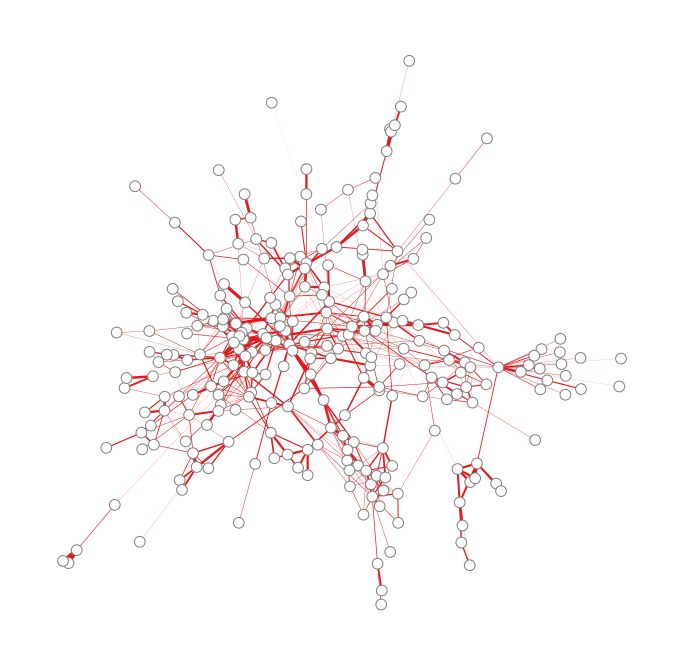

In [60]:
cs.draw_graph(
    G_bluetooth_first_day_max, 
    node_pos=vp_bluetooth_first_day_max_node_pos, 
    node_color=None, 
    node_border_width=1, 
    edge_color='#e41a1c', 
    edge_width_factor=.05, 
    figsize='large', 
    png='G_bluetooth_first_day_max'
)

### Network of phone calls
Using all relations over four weeks, sum durations, remove atempted calls, then log the sum:

In [61]:
calls_sum = calls[['user_id_from', 'user_id_to', 'duration']].groupby(['user_id_from', 'user_id_to']).sum().reset_index()
calls_sum = calls_sum[calls_sum['duration'] > 1]
calls_sum.loc[:, 'duration_log'] = np.log10(calls_sum['duration'])
calls_sum = calls_sum[['user_id_from', 'user_id_to', 'duration_log']]

In [62]:
calls_sum['duration_log'].max()

3.921842481405858

In [63]:
G_calls_sum = cs.construct_graph(
    directed=True, 
    multiplex=False, 
    graph_name='calls_sum', 
    node_list=users, 
    edge_list=calls_sum, 
    node_label='user'
)

In [64]:
G_calls_sum = G_calls_sum.subgraph(max(nx.connected_components(nx.to_undirected(G_calls_sum)), key=len))

In [65]:
vp_calls_sum_node_pos = nx.spring_layout(G_calls_sum, iterations=50)

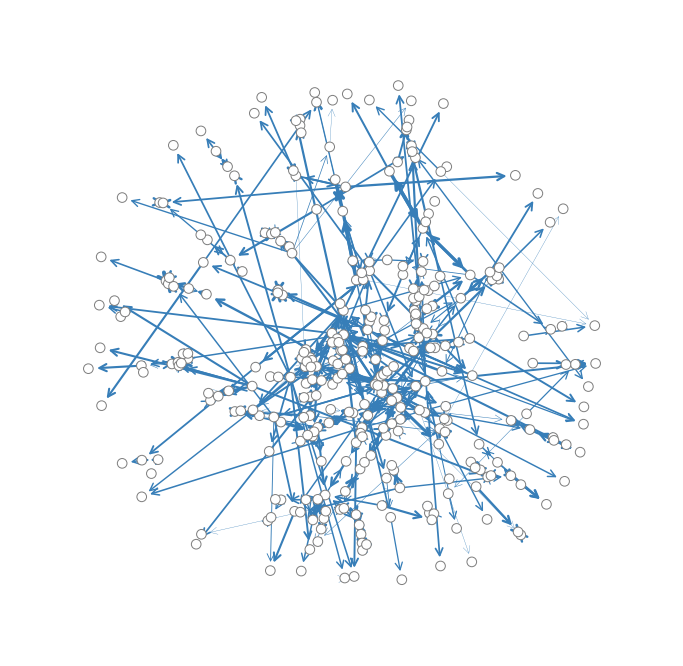

In [66]:
cs.draw_graph(
    G_calls_sum, 
    node_pos=vp_calls_sum_node_pos, 
    node_color=None, 
    node_border_width=1, 
    edge_width_factor=1, 
    edge_color='#377eb8', 
    figsize='large', 
    png='G_calls_sum'
)

### Network of text messages
Using all relations over four weeks, count the messages, remove relations with only one message, and log the count variable:

In [67]:
sms_size = sms.groupby(['user_id_from', 'user_id_to']).size().reset_index()
sms_size.rename(columns={0: 'size'}, inplace=True)
sms_size = sms_size[sms_size['size'] > 1]
sms_size.loc[:, 'size_log'] = np.log10(sms_size['size'])
sms_size = sms_size[['user_id_from', 'user_id_to', 'size_log']]

In [68]:
G_sms_size = cs.construct_graph(
    directed=True, 
    multiplex=False, 
    graph_name='sms_size', 
    node_list=users, 
    edge_list=sms_size, 
    node_label='user'
)

In [69]:
G_sms_size = G_sms_size.subgraph(max(nx.connected_components(nx.to_undirected(G_sms_size)), key=len))

In [70]:
vp_sms_size_node_pos = nx.spring_layout(G_sms_size, iterations=100)

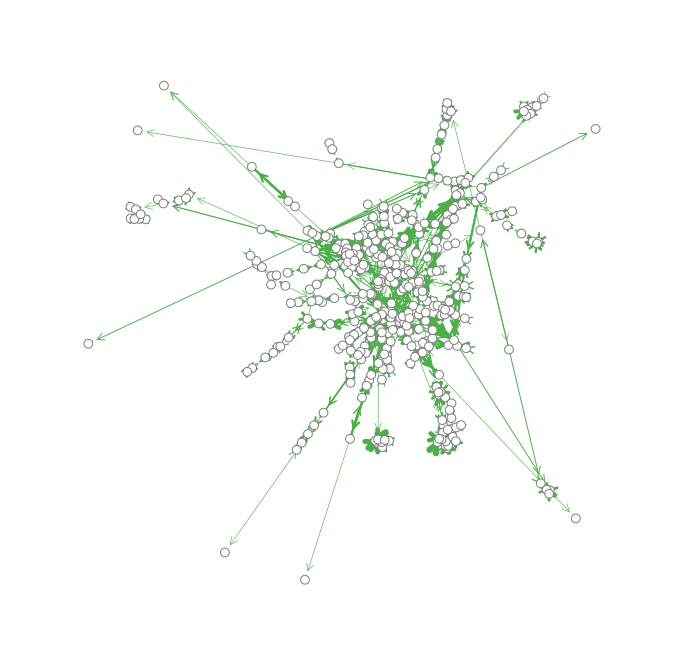

In [71]:
cs.draw_graph(
    G_sms_size, 
    node_pos=vp_sms_size_node_pos, 
    node_color=None, 
    node_border_width=1, 
    edge_width_factor=2, 
    edge_color='#4daf4a', 
    figsize='large', 
    png='G_sms_size'
)

### Network of Facebook friendships
the `construct_graph()` function needs weighted edge lists as an input:

In [72]:
facebook_friends['weight'] = 1

In [73]:
G_facebook_friends = cs.construct_graph(
    directed=False, 
    multiplex=False, 
    graph_name='facebook_friends', 
    node_list=users, 
    edge_list=facebook_friends, 
    node_label='user'
)

In [74]:
G_facebook_friends = G_facebook_friends.subgraph(max(nx.connected_components(nx.to_undirected(G_facebook_friends)), key=len))

In [75]:
vp_facebook_friends_node_pos = nx.spring_layout(G_facebook_friends, iterations=100)

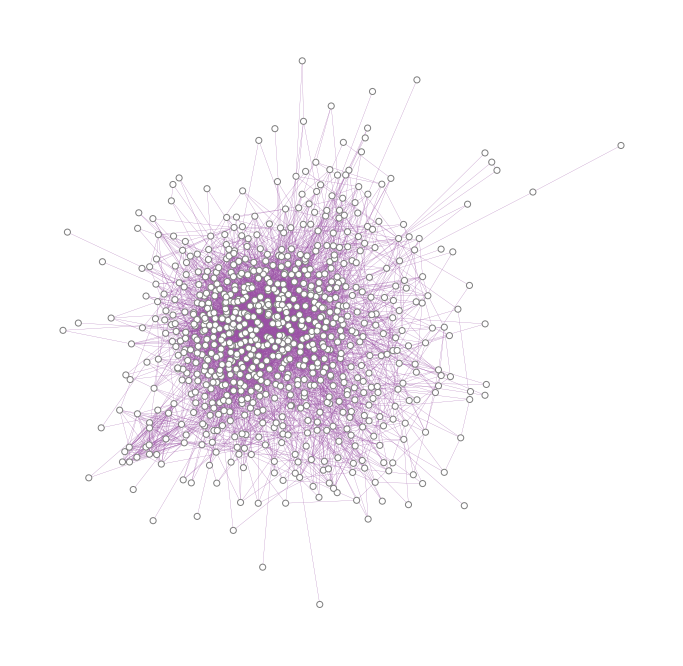

In [76]:
cs.draw_graph(
    G_facebook_friends, 
    node_pos=vp_facebook_friends_node_pos, 
    node_color=None, 
    node_border_width=1, 
    edge_width_factor=.2, 
    edge_color='#984ea3', 
    figsize='large', 
    png='G_facebook_friends'
)